In [ ]:
library(tidyverse)
library(naniar)
library(visdat)
library(ggplot2)
library(lubridate)
library(gridExtra)
library(GGally)
library(corrr)
library(dplyr)
library(car)
library(mgcv)
library(ggfortify)
library(reshape)
library(optimx)

### 1. Initial data load and feature subset/tranform etc. 

In [2]:
# data = read.csv('data/fatal-police-shootings-data.csv', na.strings=c("","NA"))
# weather&policeshootings.csv
data = read.csv('data/trimmed_weather_police.csv', na.strings=c("","NA"))

In [3]:
dim(data)
names(data)

[1] 6579   28

[1] "X"                       "id"                     
 [3] "name"                    "date"                   
 [5] "manner_of_death"         "armed"                  
 [7] "age"                     "gender"                 
 [9] "race"                    "city"                   
[11] "state"                   "signs_of_mental_illness"
[13] "threat_level"            "flee"                   
[15] "body_camera"             "longitude"              
[17] "latitude"                "is_geocoding_exact"     
[19] "smha_exp_per_capita"     "smi_prevalance"         
[21] "temp"                    "humidity"               
[23] "precipprob"              "snow"                   
[25] "pressure"                "uvindex"                
[27] "moonphase"               "precip"

#### Drop features as necessary

In [4]:
features_to_keep = c("date","armed","age","gender","race","state","flee","body_camera","signs_of_mental_illness",
                    "snow", "pressure","uvindex","moonphase","precip")
data = data[, (names(data) %in% features_to_keep)]

#### Convert features to desired datatypes

In [5]:
factor_cols = c("armed", "gender", "race", "state", "flee", "body_camera", "signs_of_mental_illness", "snow", "precip")
numeric_cols = c("age", "pressure","uvindex","moonphase")

data <- data %>% 
    mutate(across(.cols=all_of(factor_cols), .fns = as.factor))
data <- data %>% 
    mutate(across(.cols=all_of(numeric_cols), .fns = as.numeric))
data <- data %>% 
    mutate(across(.cols="date", .fns = as_date))

#### Transform features as required

In [6]:
# For some reason, this kept throwing an error for me, so I tried another method
data = data %>% 
  mutate(armed = case_when(
    armed == "gun" ~ "gun",
    armed == "knife" ~ "knife",
    armed == "vehicle" ~ "vehicle",
    armed == "unarmed" ~ "unarmed",
    armed == "undetermined" ~ "undetermined",
    TRUE ~ "other",
  )
)

In [7]:
# Race -> Combine A/N/O/NA under O?
data = data %>% 
  mutate(race = case_when(
    race == "W" ~ "W",
    race == "B" ~ "B",
    race == "H" ~ "H",
    TRUE ~ "O",
  )
)
data$race = as.factor(data$race)
summary(data$race)

B    H    O    W 
1500 1046 1194 2839

In [8]:
# Fleeing -> convert NA to 'Missing'
data = data %>% 
  mutate(flee = case_when(
    flee == "Car" ~ "Car",
    flee == "Foot" ~ "Foot",
    flee == "Not fleeing" ~ "Not fleeing",
    flee == "Other" ~ "Other",
    TRUE ~ "Missing",
  )
)
data$flee = as.factor(data$flee)
summary(data$flee)

Car        Foot     Missing Not fleeing       Other 
       1034         852         565        3888         240

### 2. Dealing with missing values

Check missing data frequency for each column

In [9]:
# Percent missing values per column
as.data.frame((colMeans(is.na(data)))*100)

,(colMeans(is.na(data))) * 100
,<dbl>
date,0.00000000
armed,0.00000000
age,5.13755890
gender,0.09119927
race,0.00000000
state,0.00000000
signs_of_mental_illness,0.00000000
flee,0.00000000
body_camera,0.00000000


Check patterns in data missingness

Warning message:
“`gather_()` was deprecated in tidyr 1.2.0.
Please use `gather()` instead.
This warning is displayed once every 8 hours.
Call `lifecycle::last_lifecycle_warnings()` to see where this warning was generated.”


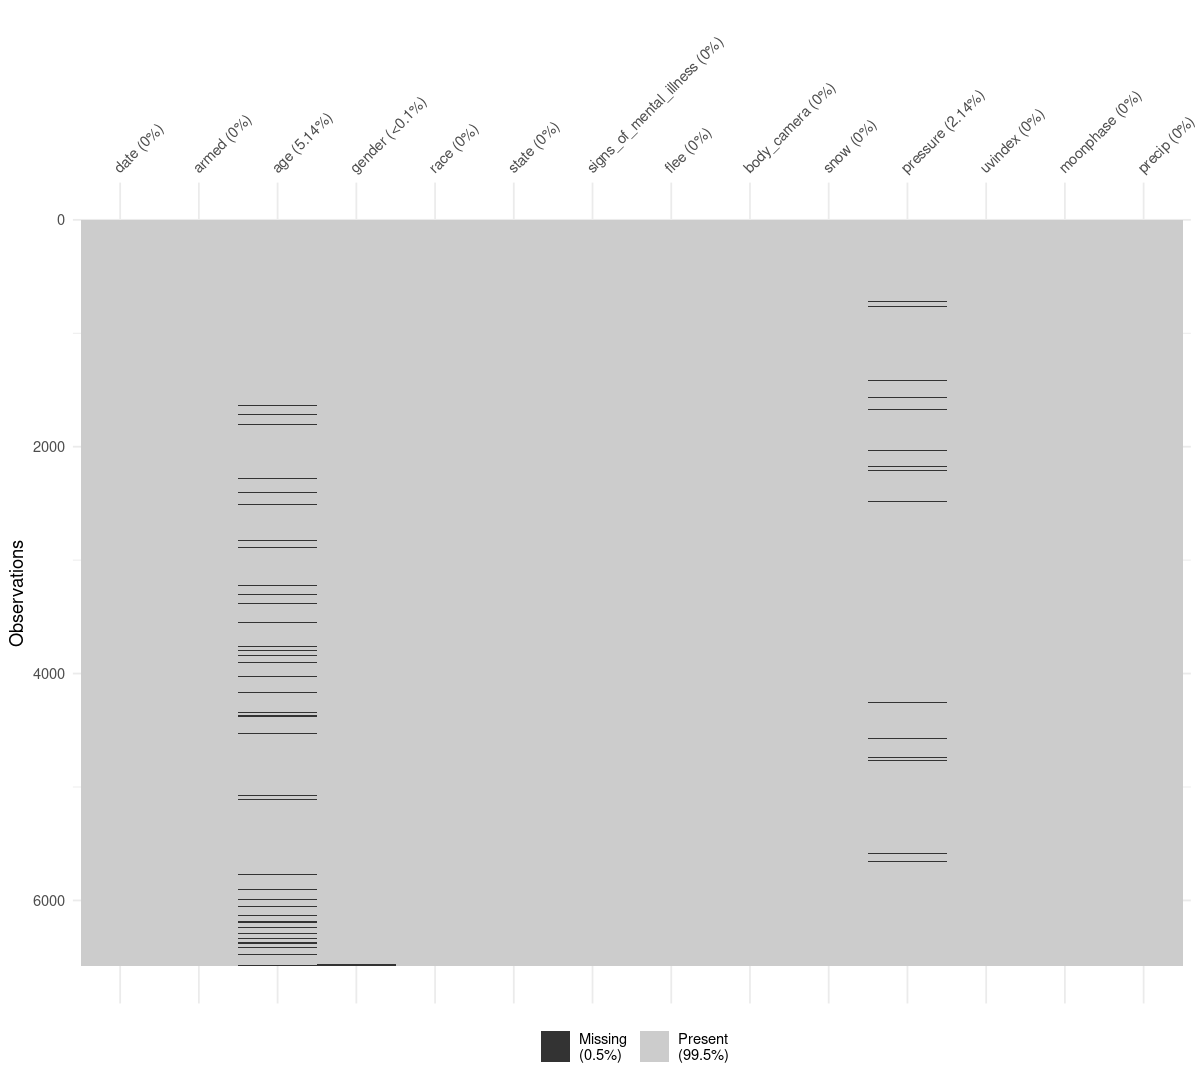

In [10]:
options(repr.plot.width=10, repr.plot.height=9)
vis_miss(data)

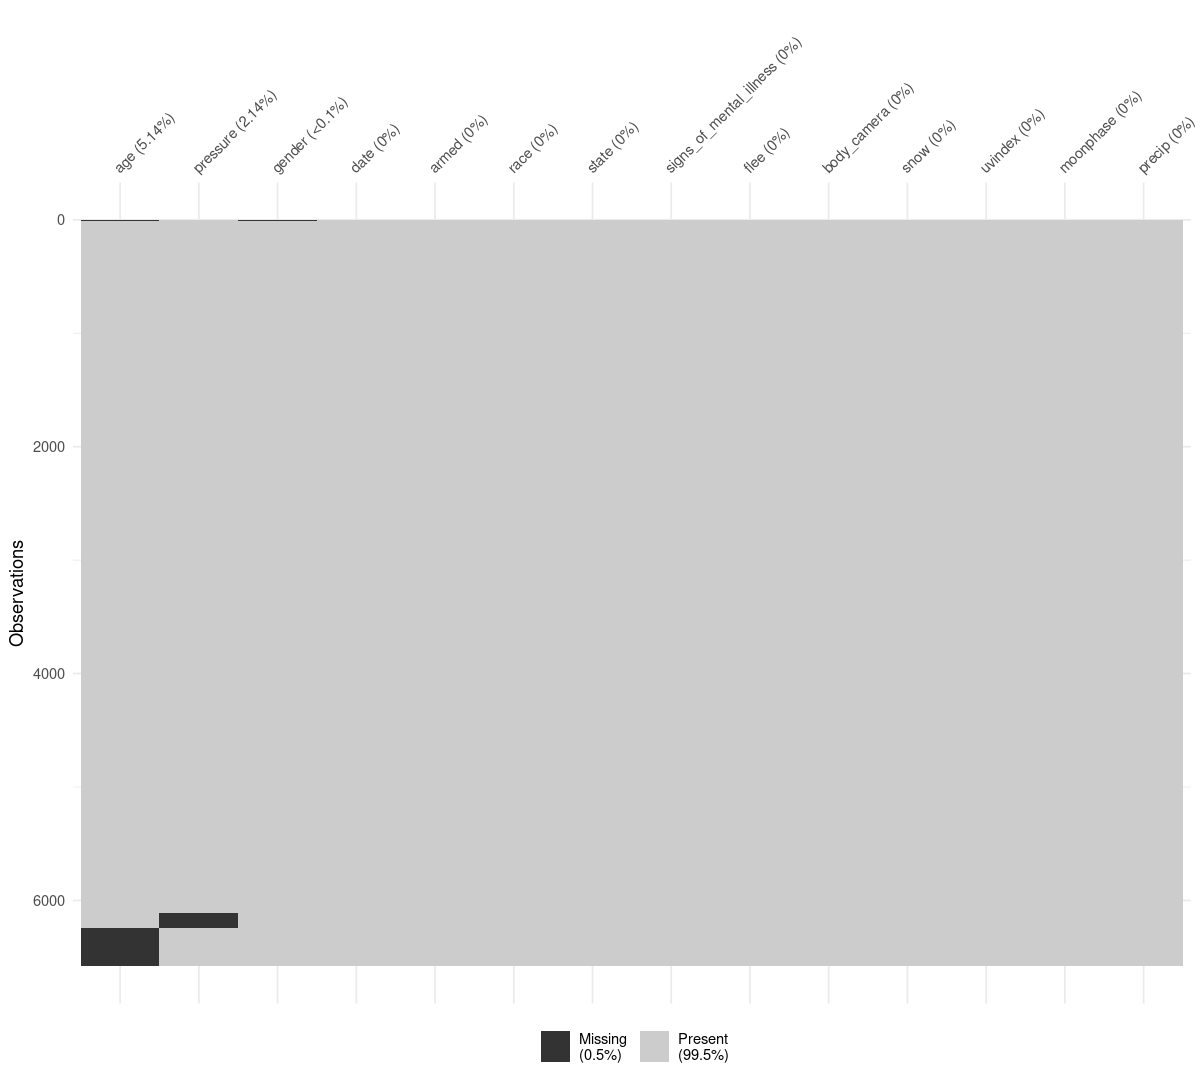

In [11]:
vis_miss(data, cluster = TRUE, sort_miss = TRUE)

In [12]:
summary(data$gender)

F    M NA's 
 305 6268    6

In [13]:
# Drop where gender is NA? The observations are too few in number to add as a category
data = data %>% drop_na(gender)

In [14]:
# Age -> use mean/median imputation?
data$age[is.na(data$age)] <- median(data$age, na.rm = T)

In [15]:
# pressure -> use mean/median imputation?
data$pressure[is.na(data$pressure)] <- median(data$pressure, na.rm = T)

> Missing values have been dealt with, but it would have been a good idea to check if the missingness pattern in age was MCAR/MAR/MNAR

In [16]:
names(data)

[1] "date"                    "armed"                  
 [3] "age"                     "gender"                 
 [5] "race"                    "state"                  
 [7] "signs_of_mental_illness" "flee"                   
 [9] "body_camera"             "snow"                   
[11] "pressure"                "uvindex"                
[13] "moonphase"               "precip"

### 3. Evaluation metric & Residual analyses plan

Since this is logistic regression and we are focused on interpretation, it may make sense to look at pure accuracy after using the model weightages as suggested by Alice, to handle the imbalanced nature of the target. Overall, we can consider the following measures:
1. Accuracy
2. AIC
3. AUROC

We should also check that there isn't high linear dependence between the factors using the VIF. `vif(glm.all)`

After models are fitted, check:
1. Histogram of residuals
2. Calibration chart
3. Inspect largest outliers?

### 4. Building model to fit data

In [17]:
library(lme4)
library(splines)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:reshape’:

    expand


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘lme4’


The following object is masked from ‘package:nlme’:

    lmList




In [18]:
names(data)

[1] "date"                    "armed"                  
 [3] "age"                     "gender"                 
 [5] "race"                    "state"                  
 [7] "signs_of_mental_illness" "flee"                   
 [9] "body_camera"             "snow"                   
[11] "pressure"                "uvindex"                
[13] "moonphase"               "precip"

In [19]:
#  1. Run the model selection process on the entire dataset:
#     + start with all features we are considering and build a logistic regression model 
#       (including weights for different classes for outcome, random effects for states, ignoring date etc.)

pos_prop = 1575/(1575 + 5706) # proportion of records where the response variable is positive
neg_prop = 1 - pos_prop
response_weights <- ifelse(data$signs_of_mental_illness == 'True', 1/pos_prop, 1/neg_prop)

In [20]:
model_overall <- glmer(signs_of_mental_illness ~ armed + age + gender + race + flee + body_camera + snow + pressure + uvindex + moonphase + precip + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall)

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0219529 (tol = 0.002, component 1)”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model is nearly unidentifiable: very large eigenvalue
 - Rescale variables?;Model is nearly unidentifiable: large eigenvalue ratio
 - Rescale variables?”

Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: signs_of_mental_illness ~ armed + age + gender + race + flee +  
    body_camera + snow + pressure + uvindex + moonphase + precip +  
    (1 | state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
 16404.3  16553.7  -8180.1  16360.3     6551 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1357 -1.2312 -0.8181 -0.4152  6.4864 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1338   0.3657  
Number of obs: 6573, groups:  state, 51

Fixed effects:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        5.338151   3.123173   1.709   0.0874 .  
armedknife         0.654128   0.053654  12.192  < 2e-16 ***
armedother         0.538600   0.052869  10.187  < 2e-16 ***
armedunarmed       0.083152   0.081851   1.016   0.3097    
armedundetermined -0.223786   0.12

In [189]:
# Pasting output from above model here (before weather stuff was added)

#      AIC      BIC   logLik deviance df.resid 
#  17975.7  18092.9  -8970.9  17941.7     7264 

# Scaled residuals: 
#     Min      1Q  Median      3Q     Max 
# -3.0932 -1.2042 -0.8086 -0.4396  7.7365 

# Random effects:
#  Groups Name        Variance Std.Dev.
#  state  (Intercept) 0.1303   0.3609  
# Number of obs: 7281, groups:  state, 51

# Fixed effects:
#                    Estimate Std. Error z value Pr(>|z|)    
# (Intercept)       -1.390851   0.130910 -10.625  < 2e-16 ***
# armedknife         0.641243   0.051171  12.531  < 2e-16 ***
# armedother         0.519466   0.050575  10.271  < 2e-16 ***
# armedunarmed       0.110407   0.078325   1.410   0.1587    
# armedundetermined -0.288672   0.117736  -2.452   0.0142 *  
# armedvehicle      -1.053089   0.153687  -6.852 7.27e-12 ***
# age                0.009940   0.001462   6.798 1.06e-11 ***
# genderM           -0.572648   0.085782  -6.676 2.46e-11 ***
# raceH              0.161392   0.067559   2.389   0.0169 *  
# raceO              0.136582   0.060416   2.261   0.0238 *  
# raceW              0.760768   0.051244  14.846  < 2e-16 ***
# fleeFoot           0.324410   0.080943   4.008 6.13e-05 ***
# fleeMissing        0.540870   0.086438   6.257 3.92e-10 ***
# fleeNot fleeing    1.255984   0.061756  20.338  < 2e-16 ***
# fleeOther         -0.013478   0.129814  -0.104   0.9173    
# body_cameraTrue    0.340131   0.051715   6.577 4.80e-11 ***


In [ ]:
# Formula: signs_of_mental_illness ~ armed + age + gender + race + flee +  
#     body_camera + snow + pressure + uvindex + moonphase + precip +  
#     (1 | state)
#    Data: data
# Weights: response_weights

#      AIC      BIC   logLik deviance df.resid 
#  16404.3  16553.7  -8180.1  16360.3     6551 

# Scaled residuals: 
#     Min      1Q  Median      3Q     Max 
# -3.1357 -1.2312 -0.8181 -0.4152  6.4864 

# Random effects:
#  Groups Name        Variance Std.Dev.
#  state  (Intercept) 0.1338   0.3657  
# Number of obs: 6573, groups:  state, 51

# Fixed effects:
#                    Estimate Std. Error z value Pr(>|z|)    
# (Intercept)        5.338151   3.123173   1.709   0.0874 .  
# armedknife         0.654128   0.053654  12.192  < 2e-16 ***
# armedother         0.538600   0.052869  10.187  < 2e-16 ***
# armedunarmed       0.083152   0.081851   1.016   0.3097    
# armedundetermined -0.223786   0.127645  -1.753   0.0796 .  
# armedvehicle      -1.155328   0.174074  -6.637 3.20e-11 ***
# age                0.010624   0.001528   6.953 3.58e-12 ***
# genderM           -0.555076   0.090046  -6.164 7.08e-10 ***
# raceH              0.087975   0.069321   1.269   0.2044    
# raceO              0.148072   0.065416   2.264   0.0236 *  
# raceW              0.729685   0.052729  13.838  < 2e-16 ***
# fleeFoot           0.397082   0.085747   4.631 3.64e-06 ***
# fleeMissing        0.598166   0.092642   6.457 1.07e-10 ***
# fleeNot fleeing    1.316724   0.066335  19.850  < 2e-16 ***
# fleeOther          0.053977   0.137071   0.394   0.6937    
# body_cameraTrue    0.361252   0.054309   6.652 2.89e-11 ***
# snowTrue          -0.098311   0.107281  -0.916   0.3595    
# pressure          -0.006641   0.003054  -2.174   0.0297 *  
# uvindex            0.007413   0.008507   0.871   0.3836    
# moonphase         -0.142289   0.060888  -2.337   0.0194 *  
# precipTrue        -0.087692   0.047416  -1.849   0.0644 .  

We notice that snow, uvindex and precipitation are insignificant, so we drop those

In [20]:
# Standardizing continuous features
data$age = scale(data$age)
data$pressure = scale(data$pressure)
data$moonphase = scale(data$moonphase)

In [21]:
model_overall <- glmer(signs_of_mental_illness ~ armed + age + gender + race + flee + body_camera + pressure + moonphase + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall)

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”

Correlation matrix not shown by default, as p = 18 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: signs_of_mental_illness ~ armed + age + gender + race + flee +  
    body_camera + pressure + moonphase + (1 | state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
   16406    16535    -8184    16368     6554 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2205 -1.2322 -0.8213 -0.4143  6.5097 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1307   0.3615  
Number of obs: 6573, groups:  state, 51

Fixed effects:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.07295    0.12796  -8.385  < 2e-16 ***
armedknife         0.65334    0.05363  12.182  < 2e-16 ***
armedother         0.53922    0.05283  10.206  < 2e-16 ***
armedunarmed       0.07473    0.08181   0.913   0.3610    
armedundetermined -0.22822    0.12749  -1.790   0.0734 .  
armedvehicle

In [22]:
# Formula: signs_of_mental_illness ~ armed + age + gender + race + flee +  
#     body_camera + pressure + moonphase + (1 | state)
#    Data: data
# Weights: response_weights

#      AIC      BIC   logLik deviance df.resid 
#    16406    16535    -8184    16368     6554 

# Scaled residuals: 
#     Min      1Q  Median      3Q     Max 
# -3.2205 -1.2322 -0.8213 -0.4143  6.5087 

# Random effects:
#  Groups Name        Variance Std.Dev.
#  state  (Intercept) 0.1307   0.3615  
# Number of obs: 6573, groups:  state, 51

# Fixed effects:
#                    Estimate Std. Error z value Pr(>|z|)    
# (Intercept)        4.478328   3.017652   1.484   0.1378    
# armedknife         0.653328   0.053631  12.182  < 2e-16 ***
# armedother         0.539233   0.052835  10.206  < 2e-16 ***
# armedunarmed       0.074731   0.081814   0.913   0.3610    
# armedundetermined -0.228163   0.127499  -1.790   0.0735 .  
# armedvehicle      -1.163010   0.174090  -6.681 2.38e-11 ***
# age                0.010472   0.001526   6.862 6.78e-12 ***
# genderM           -0.557205   0.090056  -6.187 6.12e-10 ***
# raceH              0.094064   0.069217   1.359   0.1742    
# raceO              0.150704   0.065363   2.306   0.0211 *  
# raceW              0.732027   0.052701  13.890  < 2e-16 ***
# fleeFoot           0.394610   0.085681   4.606 4.11e-06 ***
# fleeMissing        0.592416   0.092494   6.405 1.50e-10 ***
# fleeNot fleeing    1.316271   0.066290  19.856  < 2e-16 ***
# fleeOther          0.056501   0.137005   0.412   0.6800    
# body_cameraTrue    0.360020   0.054305   6.630 3.37e-11 ***
# pressure          -0.005774   0.002964  -1.948   0.0514 .  
# moonphase         -0.141786   0.060872  -2.329   0.0198 *  


Interpretation:
1. It appears that being armed is a significant factor in increasing the perception of mental illness in fatal encounters. However, being armed with a vehicle actually decreases the perception. 
2. Age is positively correlated with signs of mental illness, but a year's increase isn't that large a factor
3. Being female signficantly increases the probability that a mental illness is perceived. 
4. The baseline for race is Black. In comparison, other races are more likely to be perceived as being mentally ill, especially White people.
5. The baseline for the fleeing effect is fleeing by car. If a person isn't fleeing, they are much more likely to be perceived as showing signs of mental illness. Similarly if they are fleeing on foot (or if fleeing info is missing). 
6. The police having a body camera increases the chances of perception of mental illness. 
7. # TO ADD WEATHER INTERPRETATION

To consider:
1. We don't have data on police encounters, but only on fatal encounters. It would be instructive to see how police having body cameras come together with perceptions of mental illness in affecting whether an encounter is fatal. 
2. For each feature, the above statement is true. 

In [24]:
# ggplot(data=data, aes(x=age)) + geom_histogram(color="black", fill="steelblue", linetype="dashed") + theme_minimal() + xlab("age")

In [23]:
#     + Experiment with splines and interactions

# Try spline on age
knots.age <- quantile(data$age, c(0.1, 0.3, 0.5, 0.7, 0.9))
model_overall_spline <- glmer(signs_of_mental_illness ~ armed + gender + ns(age, knots=knots.age) + race + flee + body_camera + pressure + moonphase + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall_spline)

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”

Correlation matrix not shown by default, as p = 23 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
signs_of_mental_illness ~ armed + gender + ns(age, knots = knots.age) +  
    race + flee + body_camera + pressure + moonphase + (1 | state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
 16389.5  16552.4  -8170.7  16341.5     6549 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1876 -1.2325 -0.8157 -0.4138  6.4317 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1332   0.3649  
Number of obs: 6573, groups:  state, 51

Fixed effects:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 -3.23609    0.65044  -4.975 6.52e-07 ***
armedknife                   0.66044    0.05372  12.294  < 2e-16 ***
armedother                   0.54929    0.05294  10.375  < 2e-16 ***
armedunarmed                 0.08504    0.08196   1.038 0.299485  

Adding a spline on age doesn't seem to have brought the AIC down by enough, and the added complexity of interpreting the different interval related coefficient seesm to make it not worth the while of fitting the spline. 

In [24]:
# Consider interactions

# Try gender*race - insignificant features and no AIC improvement
model_overall_inter1 <- glmer(signs_of_mental_illness ~ armed + gender + age + race + flee + body_camera + pressure + moonphase + gender*race + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall_inter1)

# Try age*race - insignificant features and no AIC improvement
model_overall_inter2 <- glmer(signs_of_mental_illness ~ armed + gender + age + race + flee + body_camera + pressure + moonphase + age*race + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall_inter2)

# Try armed*race - a features were significant, but AIC only dropped form 8810 to 8807, so not enough for inclusion
model_overall_inter3 <- glmer(signs_of_mental_illness ~ armed + gender + age + race + flee + body_camera + pressure + moonphase + armed*race + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall_inter3)

# Try flee*race - relatively insignificant features and no AIC improvement
model_overall_inter4 <- glmer(signs_of_mental_illness ~ armed + gender + age + race + flee + body_camera + pressure + moonphase + flee*race + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall_inter4)

# Try body_camera*race - insignificant features and no AIC improvement
model_overall_inter5 <- glmer(signs_of_mental_illness ~ armed + gender + age + race + flee + body_camera + pressure + moonphase + body_camera*race + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall_inter5)

# Try gender*age - insignificant features and no AIC improvement
model_overall_inter6 <- glmer(signs_of_mental_illness ~ armed + gender + age + race + flee + body_camera + pressure + moonphase + gender*age + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall_inter6)

# Try armed*body_camera - relatively insignificant features and no AIC improvement
model_overall_inter7 <- glmer(signs_of_mental_illness ~ armed + gender + age + race + flee + body_camera + pressure + moonphase + armed*body_camera + (1|state), 
                    data=data, family="binomial", weights=response_weights)
summary(model_overall_inter7)

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00612073 (tol = 0.002, component 1)”

Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: signs_of_mental_illness ~ armed + gender + age + race + flee +  
    body_camera + pressure + moonphase + gender * race + (1 |      state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
 16408.6  16557.9  -8182.3  16364.6     6551 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0151 -1.2320 -0.8215 -0.4153  6.5173 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1304   0.3611  
Number of obs: 6573, groups:  state, 51

Fixed effects:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -0.84035    0.22979  -3.657 0.000255 ***
armedknife         0.65059    0.05367  12.122  < 2e-16 ***
armedother         0.54047    0.05285  10.227  < 2e-16 ***
armedunarmed       0.07382    0.08185   0.902 0.367102    
armedundetermined -0.22537    0.12749  -1.768 0.07

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”

Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: signs_of_mental_illness ~ armed + gender + age + race + flee +  
    body_camera + pressure + moonphase + age * race + (1 | state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
 16399.9  16549.3  -8178.0  16355.9     6551 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.1326 -1.2370 -0.8165 -0.4105  6.6421 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1322   0.3636  
Number of obs: 6573, groups:  state, 51

Fixed effects:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.06064    0.12859  -8.248  < 2e-16 ***
armedknife         0.64746    0.05378  12.039  < 2e-16 ***
armedother         0.53067    0.05302  10.009  < 2e-16 ***
armedunarmed       0.06577    0.08201   0.802  0.42260    
armedundetermined -0.22232    0.12771  -1.741  0.08172 .  

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”
Warning message in vcov.merMod(object, use.hessian = use.hessian):
“variance-covariance matrix computed from finite-difference Hessian is
not positive definite or contains NA values: falling back to var-cov estimated from RX”
Warning message in vcov.merMod(object, correlation = correlation, sigm = sig):
“variance-covariance matrix computed from finite-difference Hessian is
not positive definite or contains NA values: falling back to var-cov estimated from RX”

Correlation matrix not shown by default, as p = 33 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: signs_of_mental_illness ~ armed + gender + age + race + flee +  
    body_camera + pressure + moonphase + armed * race + (1 |      state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
 16346.4  16577.3  -8139.2  16278.4     6539 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0045 -1.2286 -0.8065 -0.4059  6.5070 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1361   0.3689  
Number of obs: 6573, groups:  state, 51

Fixed effects:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)              -1.35648    0.13435 -10.097  < 2e-16 ***
armedknife                1.24894    0.12158  10.273  < 2e-16 ***
armedother                1.04766    0.11900   8.804  < 2e-16 ***
armedunarmed              0.71127    0.14564   4.884 1.04e-06 ***
armedundetermine

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”

Correlation matrix not shown by default, as p = 30 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: signs_of_mental_illness ~ armed + gender + age + race + flee +  
    body_camera + pressure + moonphase + flee * race + (1 | state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
 16386.2  16596.7  -8162.1  16324.2     6542 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2278 -1.2366 -0.8200 -0.3561  7.6681 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1311   0.3621  
Number of obs: 6573, groups:  state, 51

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -0.68676    0.16427  -4.181 2.91e-05 ***
armedknife             0.65350    0.05379  12.150  < 2e-16 ***
armedother             0.53559    0.05297  10.111  < 2e-16 ***
armedunarmed           0.07727    0.08189   0.944 0.345400    
armedundetermined     -0.21600    0.1

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”

Correlation matrix not shown by default, as p = 21 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: signs_of_mental_illness ~ armed + gender + age + race + flee +  
    body_camera + pressure + moonphase + body_camera * race +      (1 | state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
 16411.1  16560.5  -8183.5  16367.1     6551 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2841 -1.2297 -0.8209 -0.4147  6.4808 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1307   0.3616  
Number of obs: 6573, groups:  state, 51

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -1.05927    0.12912  -8.204 2.33e-16 ***
armedknife             0.65359    0.05365  12.181  < 2e-16 ***
armedother             0.53792    0.05285  10.177  < 2e-16 ***
armedunarmed           0.07405    0.08184   0.905  0.36559    
armedundetermined     -0.

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”

Correlation matrix not shown by default, as p = 19 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: signs_of_mental_illness ~ armed + gender + age + race + flee +  
    body_camera + pressure + moonphase + gender * age + (1 |      state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
 16406.1  16541.9  -8183.1  16366.1     6553 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4723 -1.2292 -0.8213 -0.4129  6.4954 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1304   0.3611  
Number of obs: 6573, groups:  state, 51

Fixed effects:
                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)       -1.08177    0.12847  -8.420  < 2e-16 ***
armedknife         0.65259    0.05364  12.166  < 2e-16 ***
armedother         0.53906    0.05283  10.203  < 2e-16 ***
armedunarmed       0.07701    0.08183   0.941   0.3467    
armedundetermined -0.23047    0.12756  -1.807   0.0

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”

Correlation matrix not shown by default, as p = 23 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: signs_of_mental_illness ~ armed + gender + age + race + flee +  
    body_camera + pressure + moonphase + armed * body_camera +      (1 | state)
   Data: data
Weights: response_weights

     AIC      BIC   logLik deviance df.resid 
 16397.4  16560.4  -8174.7  16349.4     6549 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2918 -1.2226 -0.8199 -0.4137  6.7165 

Random effects:
 Groups Name        Variance Std.Dev.
 state  (Intercept) 0.1333   0.3651  
Number of obs: 6573, groups:  state, 51

Fixed effects:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       -1.05286    0.12846  -8.196 2.48e-16 ***
armedknife                         0.61520    0.05834  10.544  < 2e-16 ***
armedother                         0.46305    0.05717   8.100 5.51e-16 ***
armedunarmed                      -0.02

We're particularly interested in exploring interactions between race and other features, yet find that including no such interactions improve our model. Few created features are significant, and none decrease AIC by a meaningful amount. We see similar results for interactions between gender and age, as well as armed and body camera.

In [25]:
#     + Use the evaluation metrics to settle on a final model that we want to stick with, check VIF

#### As of now, proceeding with the original model w/o splines or interactions

library(InformationValue)

# Accuracy
threshold = 0.5
probs = predict(model_overall, type="response")
pred = ifelse(probs > threshold, 'True', 'False')

accuracy = sum(pred == data$signs_of_mental_illness) / length(pred)
print(accuracy)

# Sensitivity and specificity
t = table(pred, data$signs_of_mental_illness)
sensitivity = t[2,2] / sum(t[,2])
specificity = t[1,1] / sum(t[,1])

t
summary(data$signs_of_mental_illness)

# VIF
vif(model_overall)

[1] 0.6400426


       
pred    False True
  False  3142  405
  True   1961 1065

False  True 
 5103  1470

,GVIF,Df,GVIF^(1/(2*Df))
armed,1.139040,5,1.013104
age,1.092148,1,1.045059
gender,1.028861,1,1.014328
race,1.101499,3,1.016242
flee,1.130990,4,1.015506
body_camera,1.018691,1,1.009302
pressure,1.002826,1,1.001412
moonphase,1.002361,1,1.001180


Using our original model without splines or transformations, we achieve an accuracy of 78.8%. Considering the target variable is 78.4% negative, we're barely beating the baseline accuracy score. Only 115 positives for signs of mental illness are correctly classified, while 1,460 true positives were incorrectly classified as negative. We have a very high specificity (0.985) but very low sensitivity (0.073).

We do not see high linear dependence between features, as all VIFs are close to 1.

In [68]:
data_with_resids = data
data_with_resids$residuals = residuals(model_overall)
write.csv(data_with_resids, "data/data_with_resids.csv", row.names = TRUE)

In [66]:
length(residuals(model_overall))

[1] 6573

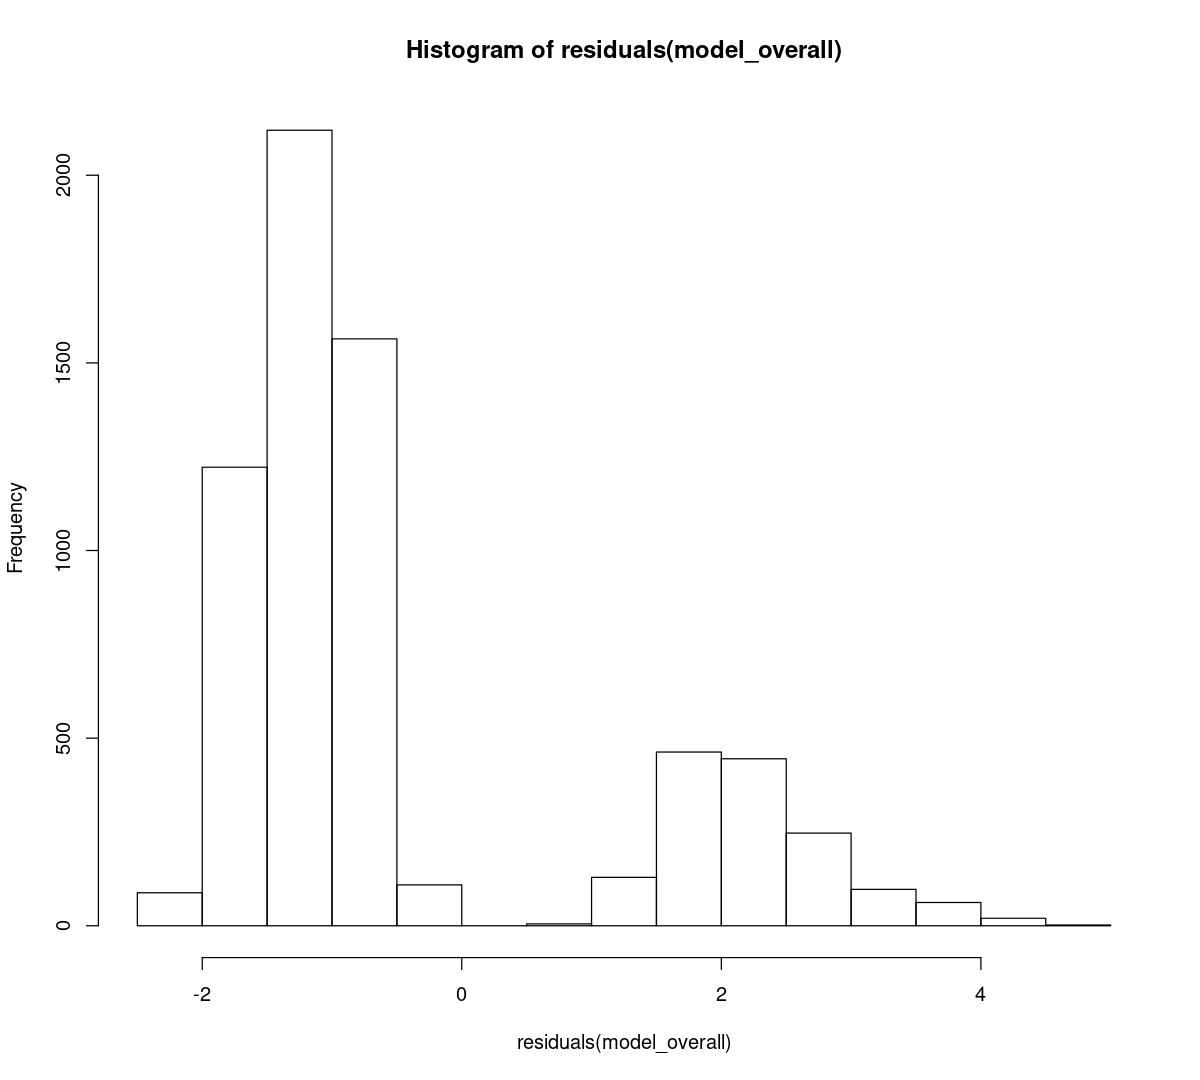

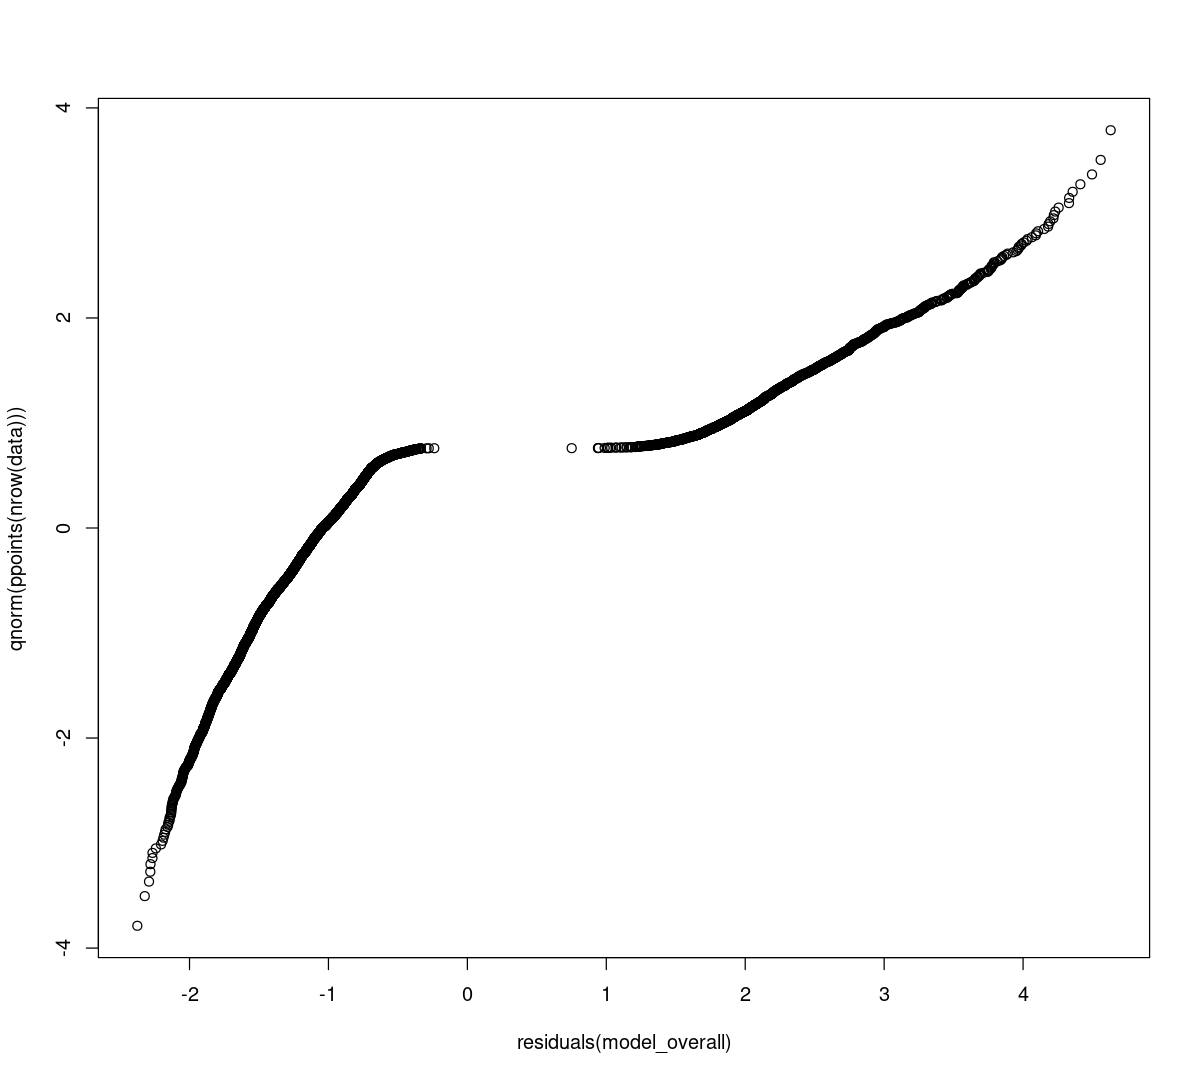

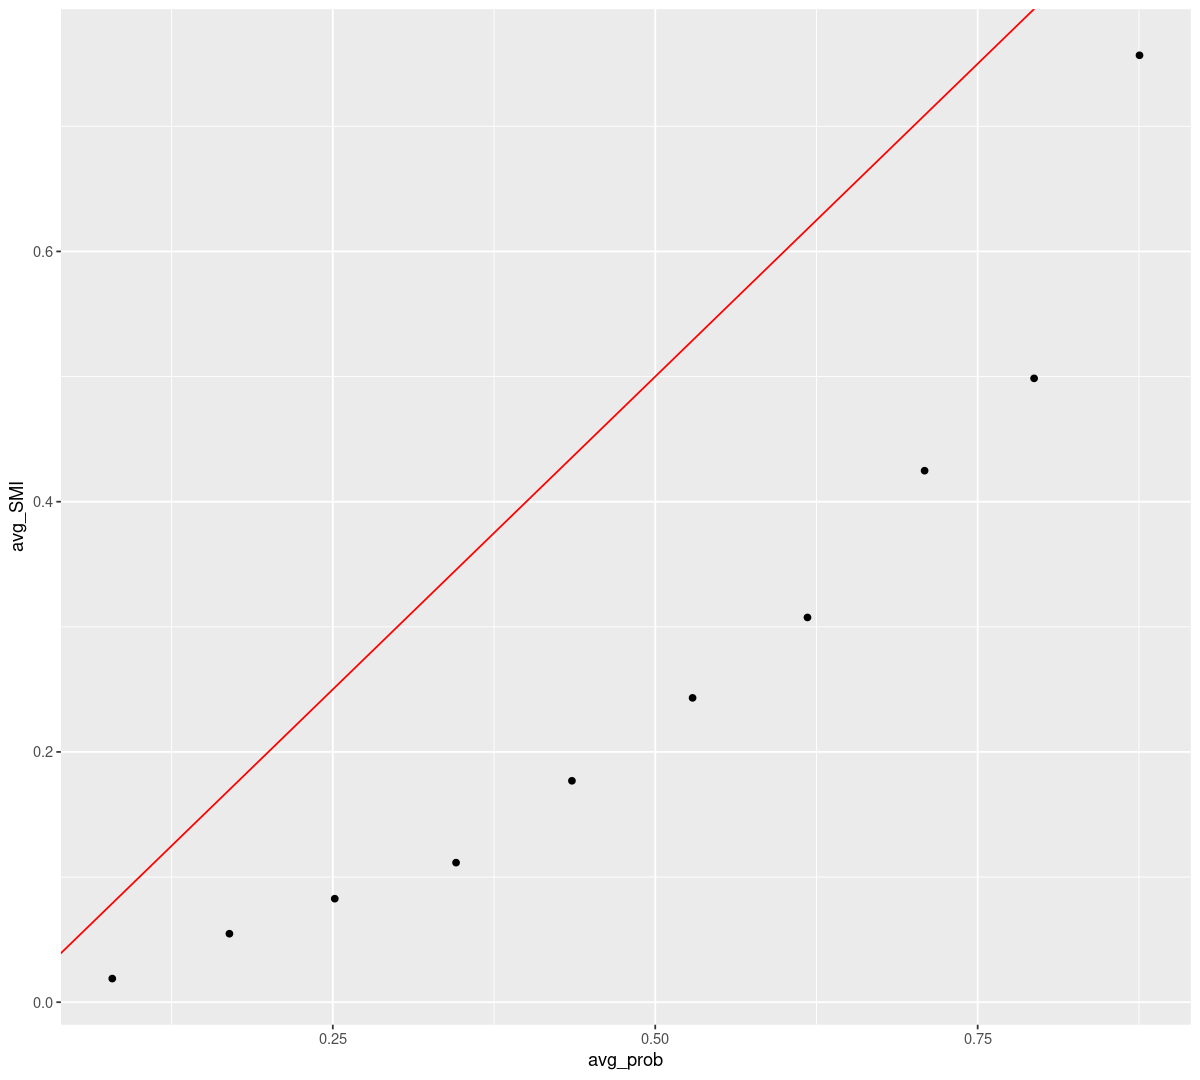

In [26]:
#     + Get a sense of goodness of fit and residuals for this overall model (we may not need this, but might as well do it)

# Histogram of residuals
hist(residuals(model_overall))

# Q-Q plot
qqplot(residuals(model_overall), qnorm(ppoints(nrow(data))))

# Calibration
data$probs = probs
# tb_df$prob_grp = ceiling(order(tb_df$probs)/135) 
data$prob_grp = cut(data$probs, 10)
calibration_df = data %>% 
  group_by(prob_grp) %>%
  summarize(avg_SMI = mean(signs_of_mental_illness=='True'), avg_prob = mean(probs))

ggplot(calibration_df) + geom_point(aes(x=avg_prob, y=avg_SMI)) +
  geom_abline(aes(slope=1, intercept=0), col="red")

The diagnostic plots for our model are not as clean as we'd like them to be - a Q-Q plot and histogram of residuals do not quite show the normality we'd like to see. The histogram of residuals specifically shows our residuals are bimodal, appearing to show a relatively normal distribution on either side of zero. Our model is well-calibrated for the first seven or eight of ten buckets, but does on average assigns lower probability of signs of mental illness to points where that average is actually higher.

In [27]:
#  2. Once this final model has been decided, split the data into batches by year, and fit the model to each batch individually
#     + Compare coefficients of fitted models across batches to interpret how things are changing/staying the same over time
#     + Also check goodness of fit and residuals for each batch

data = data %>% mutate(yr = year(date))
data$rw = response_weights
aggregate(data$yr, by=list(data$yr), FUN=length)

Group.1,x
<dbl>,<int>
2015,994
2016,925
2017,944
2018,914
2019,945
2020,926
2021,768
2022,157


In [28]:
# Splitting into batches

batch_features_to_keep = c("armed","age","gender","race","state","flee","body_camera","signs_of_mental_illness", "pressure", "moonphase")

batch_1 = data[data$yr %in% c(2015, 2016), ]
batch_1 = batch_1[, (names(batch_1) %in% batch_features_to_keep)]


batch_2 = data[data$yr %in% c(2017, 2018), ]
batch_2 = batch_2[, (names(batch_2) %in% batch_features_to_keep)]

batch_3 = data[data$yr %in% c(2019, 2020), ]
batch_3 = batch_3[, (names(batch_3) %in% batch_features_to_keep)]

batch_4 = data[data$yr %in% c(2021, 2022), ]
batch_4 = batch_4[, (names(batch_4) %in% batch_features_to_keep)]

In [29]:
get_pos_weight <- function(smi) {
    pos_count = length(smi[smi == 'True'])
    return (pos_count/(length(smi)))
}


length(batch_1$signs_of_mental_illness[batch_1$signs_of_mental_illness == 'True'])
length(batch_1$signs_of_mental_illness[batch_1$signs_of_mental_illness == 'False'])

[1] 504

[1] 1415

In [35]:
# Fitting models

pos_wt = get_pos_weight(batch_1$signs_of_mental_illness)
neg_wt = 1 - pos_wt
b1_weights <- ifelse(batch_1$signs_of_mental_illness == 'True', 1/pos_wt, 1/neg_wt)


model1 <- glmer(signs_of_mental_illness ~ armed + age + gender + race + flee + body_camera + pressure + moonphase + (1|state), 
            data=batch_1, family="binomial", weights=b1_weights)

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”


In [50]:
# Using optimx
pos_wt = get_pos_weight(batch_2$signs_of_mental_illness)
neg_wt = 1 - pos_wt
b2_weights <- ifelse(batch_2$signs_of_mental_illness == 'True', 1/pos_wt, 1/neg_wt)

model2 <- glmer(signs_of_mental_illness ~ armed + age + gender + race + flee + body_camera + pressure + moonphase + (1|state), 
            data=batch_2, family="binomial", weights=b2_weights, 
            control = glmerControl(optimizer ='optimx', optCtrl=list(method='nlminb')))

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”


In [36]:
pos_wt = get_pos_weight(batch_3$signs_of_mental_illness)
neg_wt = 1 - pos_wt
b3_weights <- ifelse(batch_3$signs_of_mental_illness == 'True', 1/pos_wt, 1/neg_wt)

model3 <- glmer(signs_of_mental_illness ~ armed + age + gender + race + flee + body_camera + pressure + moonphase + (1|state), 
            data=batch_3, family="binomial", weights=b3_weights)

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”


In [49]:
# Using optimx
pos_wt = get_pos_weight(batch_4$signs_of_mental_illness)
neg_wt = 1 - pos_wt
b4_weights <- ifelse(batch_4$signs_of_mental_illness == 'True', 1/pos_wt, 1/neg_wt)

model4 <- glmer(signs_of_mental_illness ~ armed + age + gender + race + flee + body_camera + pressure + moonphase + (1|state), 
            data=batch_4, family="binomial", weights=b4_weights,
            control = glmerControl(optimizer ='optimx', optCtrl=list(method='nlminb')))

[1] ""

[1] "THIS IS NOT CONVERGING WITH WEIGHTS, SO CURRENTLY RUN WITHOUT WEIGHTS"

[1] ""

Warning message in eval(family$initialize, rho):
“non-integer #successes in a binomial glm!”


In [51]:
# Pulling coefficients and intercepts -> will take some manipulation, but should be doable
mod1_coef_df = coef(model1)["state"]$state
mod2_coef_df = coef(model2)["state"]$state
mod3_coef_df = coef(model3)["state"]$state
mod4_coef_df = coef(model4)["state"]$state

In [53]:
# Creating dataframe of intercepts for each state

b1_15_16 = mod1_coef_df[1]
b1_15_16["state"] = row.names(b1_15_16)
colnames(b1_15_16)[1] <- 16
b2_17_18 = mod2_coef_df[1]
b2_17_18["state"] = row.names(b2_17_18)
colnames(b2_17_18)[1] <- 18
b3_19_20 = mod3_coef_df[1]
b3_19_20["state"] = row.names(b3_19_20)
colnames(b3_19_20)[1] <- 20
b3_21_22 = mod4_coef_df[1]
b3_21_22["state"] = row.names(b3_21_22)
colnames(b3_21_22)[1] <- 22


state_intercepts = merge(b1_15_16, b2_17_18, by = "state", all = TRUE)
state_intercepts = merge(state_intercepts, b3_19_20, by = "state", all = TRUE)
state_intercepts = merge(state_intercepts, b3_21_22, by = "state", all = TRUE)

# RI does not have any shootings in batch 3
t(state_intercepts)

state,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,⋯,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
16,-1.7971999,-1.1807380,-1.5737939,-1.2461223,-1.2251791,-1.6475574,-1.2553647,-1.0045985,-1.1016145,-1.1531313,⋯,-0.8679586,-1.4363163,-1.2614729,-0.9465644,-0.6128183,-1.3283476,-0.4130121,-1.3702088,-1.2893017,-1.3996862
18,-1.7891231,-1.9274074,-2.7117297,-2.4883879,-1.5314391,-2.2815712,-1.8723016,-2.1617065,-1.8593697,-1.0456860,⋯,-1.7838368,-1.2582994,-1.9423070,-1.3979152,-1.5338537,-0.6743656,-1.3860415,-1.6873917,-1.1437676,-1.4166268
20,-0.77445524,-0.41256338,-0.61657278,-1.23802201,-1.07027213,-1.40741560,-0.15545989,-1.04950130,-0.35154918,-0.82721424,⋯,-0.65139111,-1.32082511,-0.81849899,-1.15597563,-1.39374495,-0.69478767,-0.37958026,-1.02085792,-1.54217788,-0.67119793
22,-2.58823017,-1.33151712,-3.73044610,-0.95992485,-1.19443771,-0.89568673,-2.30433196,-1.32569310,-2.32389347,-1.08072022,⋯,-0.52652242,-0.69919553,-0.40316261,-2.87965954,-0.40931144,-2.04168843,-1.63502187,0.26726195,-2.87394450,-1.82838498


In [54]:
# Separate the random effects from the overall intercepts
state_intercepts[,2] = state_intercepts[,2] - mean(state_intercepts[,2], na.rm=TRUE)
state_intercepts[,3] = state_intercepts[,3] - mean(state_intercepts[,3], na.rm=TRUE)
state_intercepts[,4] = state_intercepts[,4] - mean(state_intercepts[,4], na.rm=TRUE)
state_intercepts[,5] = state_intercepts[,5] - mean(state_intercepts[,5], na.rm=TRUE)

In [55]:
# Convert data from wide to long
Molten <- melt(state_intercepts, id.vars = "state")
head(Molten)
Molten$variable = as.numeric(Molten$variable)
Molten$value = as.numeric(Molten$value)

,state,variable,value
,<chr>,<fct>,<dbl>
1,AK,16,-0.548675424
2,AL,16,0.067786451
3,AR,16,-0.325269510
4,AZ,16,0.002402085
5,CA,16,0.023345305
6,CO,16,-0.399032998


Warning message:
“Removed 2 row(s) containing missing values (geom_path).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


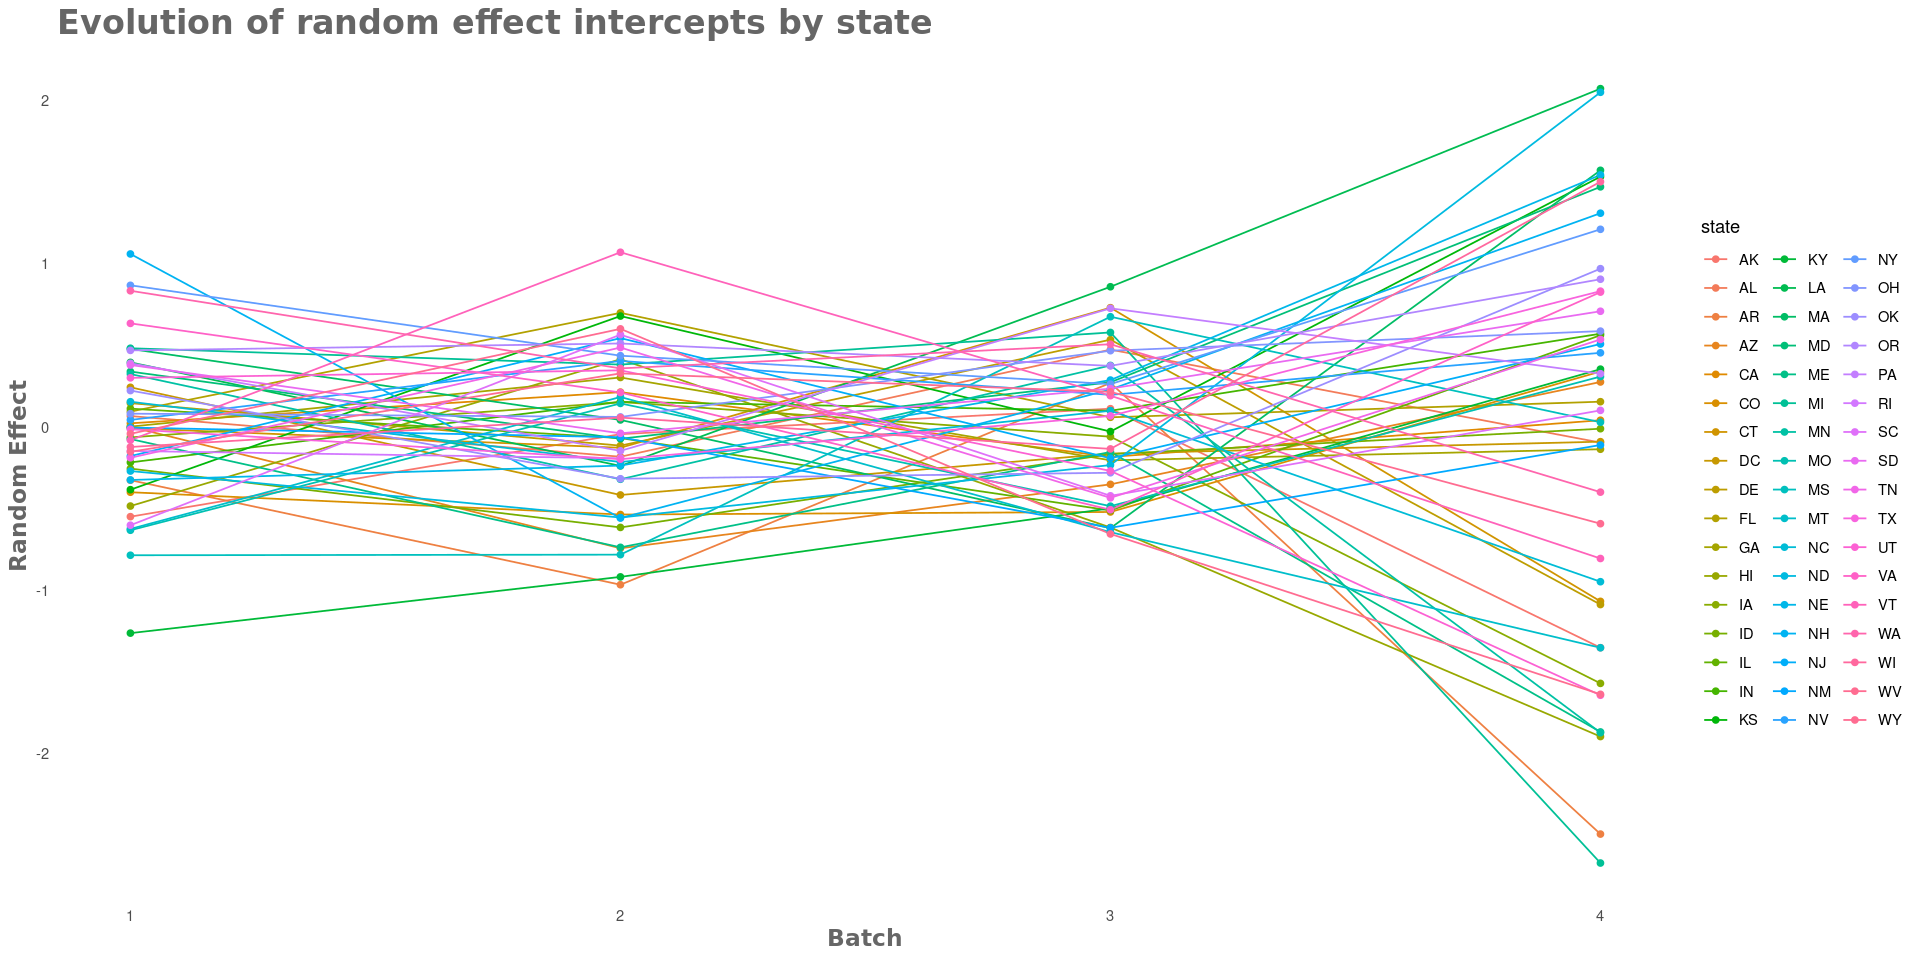

In [70]:
options(repr.plot.width=16, repr.plot.height=8)
ggplot(data=Molten,
       aes(x=variable, y=value, colour=state)) +
       geom_line() + geom_point() + theme_minimal() +
       xlab("Batch") +
       ylab("Random Effect") +
       ggtitle("Evolution of random effect intercepts by state") + 
       theme(plot.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=20, hjust=0)) + 
       theme(axis.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=14)) + 
       theme(panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              panel.border = element_blank(),
              panel.background = element_blank())

In [57]:
# Now looking at other coefficients
coeffs_df = mod1_coef_df[1, 2:dim(mod1_coef_df)[2]]
r2 = mod2_coef_df[1, 2:dim(mod1_coef_df)[2]]
r3 = mod3_coef_df[1, 2:dim(mod1_coef_df)[2]]
r4 = mod4_coef_df[1, 2:dim(mod1_coef_df)[2]]


In [58]:
coeffs_df[nrow(coeffs_df) + 1,] = r2
coeffs_df[nrow(coeffs_df) + 1,] = r3
coeffs_df[nrow(coeffs_df) + 1,] = r4
rownames(coeffs_df) <- c("2016", "2018", "2020", "2022")

In [59]:
coeffs_df$batch = c(2016,2018,2020,2022)
coeffs_df

,armedknife,armedother,armedunarmed,armedundetermined,armedvehicle,age,genderM,raceH,raceO,raceW,fleeFoot,fleeMissing,fleeNot fleeing,fleeOther,body_cameraTrue,pressure,moonphase,batch
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016,0.6617803,0.5291045,0.09721935,-1.0927539,0.4426539,0.07576398,-0.6824431,0.433356756,0.78933342,1.022592899,0.02365121,-0.5303286,1.228651,-0.4946309,0.02919355,-0.09811705,-0.05047231,2016
2018,0.7605928,0.2647062,-0.02697427,0.5450334,-1.4232084,0.17447146,-0.1802212,-0.009115597,0.01692758,0.563861487,0.69416831,0.7670700,1.642457,1.0187068,0.67120985,-0.07484918,-0.08725457,2018
2020,0.5970047,0.8992466,0.09637792,-1.6823625,-1.7071138,0.23341094,-0.7835027,0.116346208,0.50551938,0.834786967,0.46722995,0.6156968,1.072680,-0.7020220,0.65321815,0.07085798,-0.01903382,2020
2022,1.1561093,0.7315095,0.74168371,0.5952196,-1.2975344,0.06679170,-0.5547597,-0.988659926,-0.37922487,0.004158751,0.76276363,1.2299924,1.601216,0.6811328,0.12443178,-0.13445751,-0.16603114,2022


In [60]:
coeffs_to_keep = names(coeffs_df)
coeffs_df = coeffs_df[, (names(coeffs_df) %in% coeffs_to_keep)]

In [61]:
# Convert data from wide to long

Molten_C <- melt(coeffs_df, id.vars = "batch")
head(Molten_C)
Molten_C$variable = as.factor(Molten_C$variable)
Molten_C$batch = as.numeric(Molten_C$batch)
Molten_C$value = as.numeric(Molten_C$value)

,batch,variable,value
,<dbl>,<fct>,<dbl>
1,2016,armedknife,0.6617803
2,2018,armedknife,0.7605928
3,2020,armedknife,0.5970047
4,2022,armedknife,1.1561093
5,2016,armedother,0.5291045
6,2018,armedother,0.2647062


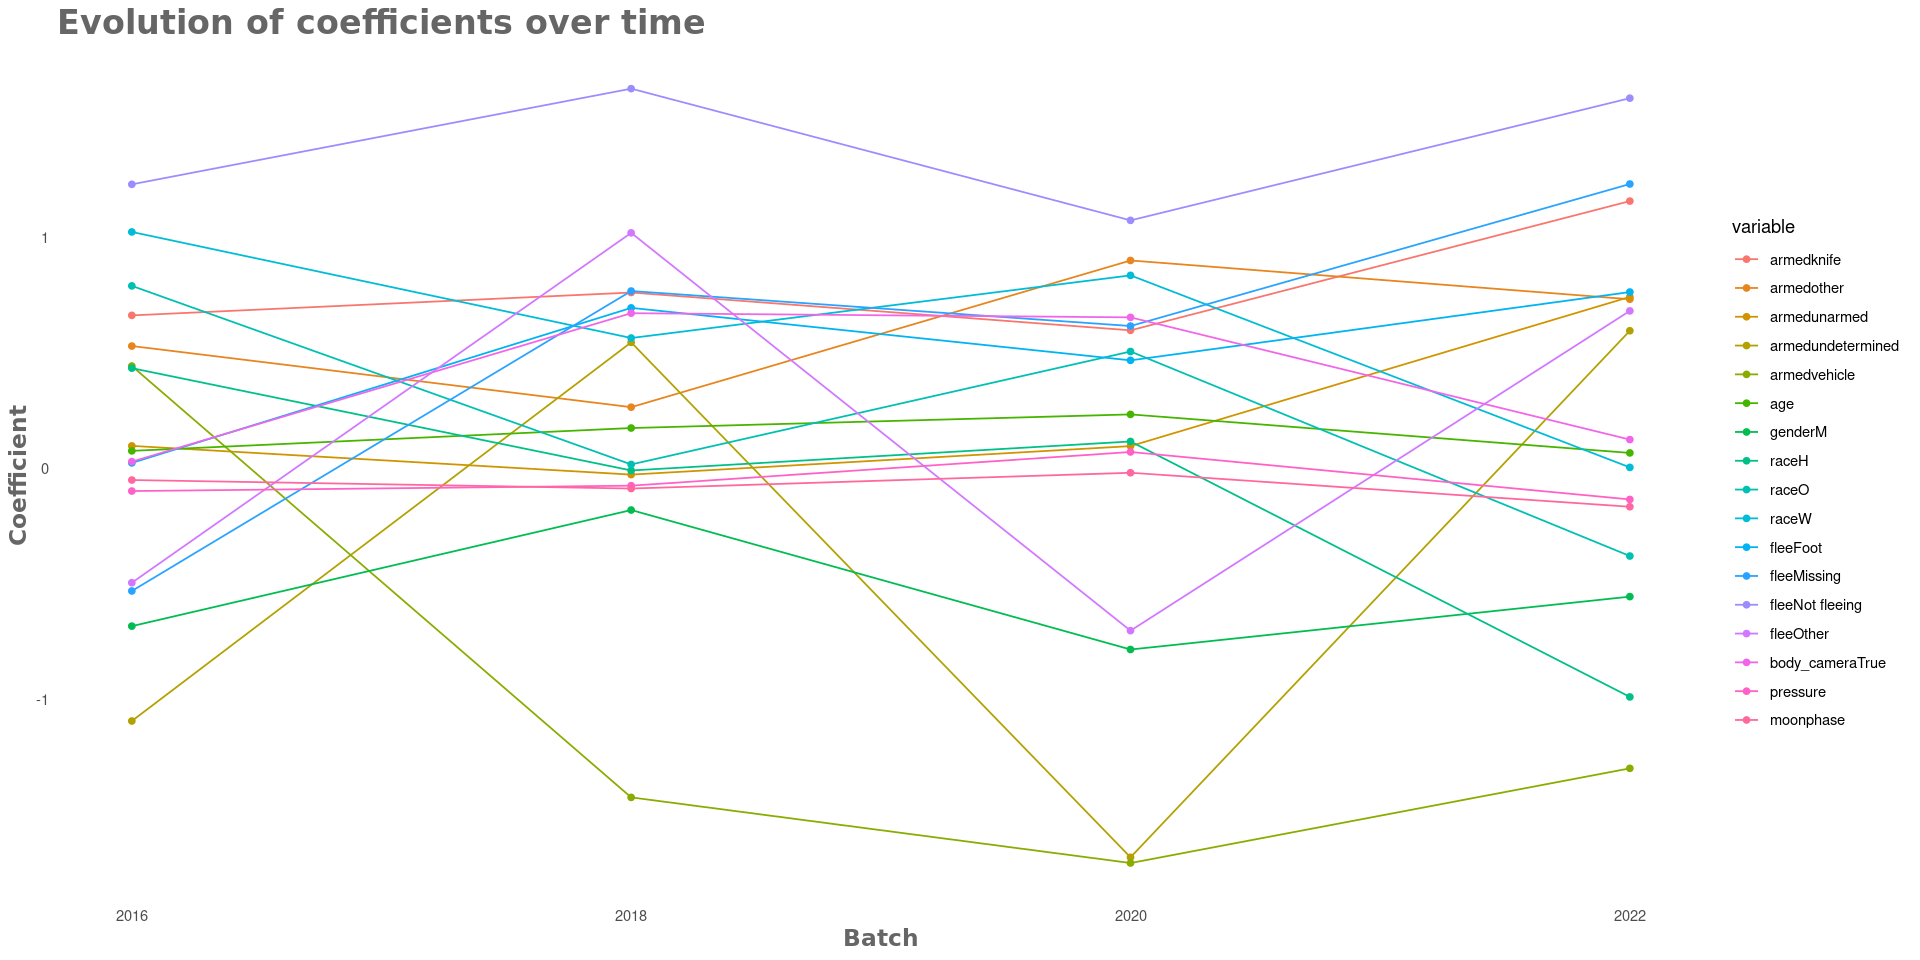

In [69]:
options(repr.plot.width=16, repr.plot.height=8)
ggplot(data=Molten_C,
       aes(x=batch, y=value, colour=variable)) +
       geom_line() + geom_point() + theme_minimal() +
       xlab("Batch") +
       ylab("Coefficient") +
       ggtitle("Evolution of coefficients over time") +
       theme(plot.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=20, hjust=0)) + 
       theme(axis.title = element_text(family = "Trebuchet MS", color="#666666", face="bold", size=14)) + 
       theme(panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              panel.border = element_blank(),
              panel.background = element_blank())

In [63]:
write.csv(coeffs_df, "data/coefficients_over_time.csv", row.names = TRUE)
write.csv(state_intercepts, "data/state_intercepts_over_time.csv", row.names = TRUE)